In [1]:
import numpy as np
import pandas as pd
import altair as alt
import warnings
warnings.filterwarnings('ignore')

## Read the data

In [2]:
# raw data
cases = pd.read_csv('data/COVID-19_Cases.csv')
vaccination = pd.read_csv('data/us_state_vaccinations - us_state_vaccinations.csv')

## Vaccination Data

In [3]:
vaccination

,date,location,total_vaccinations,total_distributed,people_vaccinated,people_fully_vaccinated_per_hundred,total_vaccinations_per_hundred,people_fully_vaccinated,people_vaccinated_per_hundred,distributed_per_hundred,daily_vaccinations_raw,daily_vaccinations,daily_vaccinations_per_million,share_doses_used,total_boosters,total_boosters_per_hundred
0,2021-01-12,Alabama,78134.0,377025.0,70861.0,0.15,1.59,7270.0,1.45,7.69,NaN,NaN,NaN,0.207,NaN,NaN
1,2021-01-13,Alabama,84040.0,378975.0,74792.0,0.19,1.71,9245.0,1.53,7.73,5906.0,5906.0,1205.0,0.222,NaN,NaN
2,2021-01-14,Alabama,92300.0,435350.0,80480.0,NaN,1.88,NaN,1.64,8.88,8260.0,7083.0,1445.0,0.212,NaN,NaN
3,2021-01-15,Alabama,100567.0,444650.0,86956.0,0.28,2.05,13488.0,1.77,9.07,8267.0,7478.0,1525.0,0.226,NaN,NaN
4,2021-01-16,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7498.0,1529.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49695,2023-02-18,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,105.0,181.0,NaN,NaN,NaN
49696,2023-02-19,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,135.0,233.0,NaN,NaN,NaN
49697,2023-02-20,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,165.0,285.0,NaN,NaN,NaN
49698,2023-02-21,Wyoming,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,196.0,339.0,NaN,NaN,NaN


In [4]:
# Create the datetime value for range but keep the original date for future use
vaccination['date'] = pd.to_datetime(vaccination['date']).dt.date

### Set the range of date
the first vaccination comes out in December 2020

In [5]:
# From 2021.1 to 2022.12
startdate = pd.to_datetime("2021-1-1").date()
enddate = pd.to_datetime("2022-12-31").date()

# Select DataFrame rows between two dates
mask = (vaccination['date'] >= startdate) & (vaccination['date'] <= enddate)
vaccination = vaccination.loc[mask].reset_index()

In [6]:
vaccination['year'] = pd.DatetimeIndex(vaccination['date']).year
vaccination['month'] = pd.DatetimeIndex(vaccination['date']).month
vaccination['day'] = pd.DatetimeIndex(vaccination['date']).day

### Remove booster term since the first booster come out on Aug. 25, 2021

In [7]:
# Remove booster
vaccination = vaccination[['location','year','month','day','total_vaccinations','total_distributed','people_vaccinated']]
vaccination = vaccination.rename(columns = {'location' : 'state'}) # rename the location into state
vaccination

,state,year,month,day,total_vaccinations,total_distributed,people_vaccinated
0,Alabama,2021,1,12,78134.0,377025.0,70861.0
1,Alabama,2021,1,13,84040.0,378975.0,74792.0
2,Alabama,2021,1,14,92300.0,435350.0,80480.0
3,Alabama,2021,1,15,100567.0,444650.0,86956.0
4,Alabama,2021,1,16,NaN,NaN,NaN
...,...,...,...,...,...,...,...
46291,Wyoming,2022,12,27,NaN,NaN,NaN
46292,Wyoming,2022,12,28,844861.0,1241825.0,351498.0
46293,Wyoming,2022,12,29,NaN,NaN,NaN
46294,Wyoming,2022,12,30,NaN,NaN,NaN


### Since the data is accumulated, we need to find the day with the largest value of each month by state

In [8]:
# Find out the maximum days
max_days = vaccination.groupby(['state', 'year','month'])['people_vaccinated'].max().reset_index()
max_days = pd.DataFrame(max_days)

# merge on the original dataset with the maximum days
vaccination_max = pd.merge(vaccination, max_days, how = 'right', on=['state', 'year','month','people_vaccinated'])
vaccination_max.loc[:,'people_vaccinated'].isna().sum()

1497

### 1497 empty values, figure out why

In [9]:
# Get a list of states containing null values
ace_data = vaccination_max.loc[:,'total_distributed']
empty_list = []
for i in range(len(vaccination_max)):
    if pd.isna(ace_data[i]) == True :
        empty_list.append(vaccination_max['state'][i])
        
pd.unique(empty_list)

array(['American Samoa', 'California', 'Dept of Defense', 'Idaho',
       'Illinois', 'Kansas', 'Long Term Care', 'Nevada', 'New Hampshire',
       'Pennsylvania', 'Puerto Rico', 'Texas', 'Wyoming'], dtype=object)

In [10]:
'''
Find out which month contains empty values for each state above
vaccination_max[(vaccination_max['state'] == 'California') & (vaccination_max['people_vaccinated'].isnull())]
'''

"\nFind out which month contains empty values for each state above\nvaccination_max[(vaccination_max['state'] == 'California') & (vaccination_max['people_vaccinated'].isnull())]\n"

Missing in 2021:
* Pennsylvania is missing November 2021
* New Hampshire is missing December 2021
* Long Term Care is missing most of the datas 2021
* Illinois is missing September and October 2021

Missing in 2022:
* Wyoming is missing all datas in April 2022
* Texas is missing all datas in May, June, July 2022
* Puerto Rico is missing most of the datas 2022
* New Hampshire is missing from June to August 2022
* Nevada is missing October and November 2022
* Kansas is missing from March to May 2022
* Illinois is missing April and May 2022
* Idaho is missing June, July 2022
* Dept of Defense is missing April and May 2022
* California is missing April, Septmber, and October 2022
* American Samoa is missing Occtober 2022

### Split the datas into two years and remove the state contains empty values from each year.

In [11]:
missing_2021 = ['Pennsylvania','Long Term Care','New Hampshire','Illinois']
missing_2022 = ['Wyoming','Texas','Puerto Rico','New Hampshire','Nevada','Kansas','Illinois','Idaho','Dept of Defense','California','American Samoa']

In [12]:
# 2021
vaccination_2021_acc = vaccination_max[(vaccination_max['year'] == 2021)]
mask = ~vaccination_2021_acc['state'].isin(missing_2021)
vaccination_2021_acc = vaccination_2021_acc[mask]
vaccination_2021_acc.isna().sum()

state                 0
year                  0
month                 0
day                   0
total_vaccinations    0
total_distributed     0
people_vaccinated     0
dtype: int64

In [13]:
# 2022
vaccination_2022_acc = vaccination_max[(vaccination_max['year'] == 2022)]
mask = ~vaccination_2022_acc['state'].isin(missing_2022)
vaccination_2022_acc = vaccination_2022_acc[mask]
vaccination_2022_acc.isna().sum()

state                 0
year                  0
month                 0
day                   0
total_vaccinations    0
total_distributed     0
people_vaccinated     0
dtype: int64

### There are some duplicate months with the same data, remove them.

In [14]:
# 2021
vaccination_2021_acc = vaccination_2021_acc.drop_duplicates(subset=["state", "year","month","total_distributed","people_vaccinated"]
                                                            , keep='first')

# 2022
vaccination_2022_acc = vaccination_2022_acc.drop_duplicates(subset=["state", "year","month","total_distributed","people_vaccinated"]
                                                            , keep='first')

#### Check if there are still duplicates (more than 12 months):
* 2021

In [15]:
# 2021
for i in pd.unique(vaccination_2021_acc['state']):
    for j in range(len(vaccination_2021_acc[vaccination_2021_acc['state'] == i])):
        if j >= 12:
            print(i)
            
# Take a look
vaccination_2021_acc[vaccination_2021_acc['state'] == 'American Samoa']

American Samoa


,state,year,month,day,total_vaccinations,total_distributed,people_vaccinated
48,American Samoa,2021,1,29,9925.0,18450.0,8926.0
51,American Samoa,2021,2,28,20338.0,29450.0,12355.0
52,American Samoa,2021,3,31,31167.0,43810.0,17856.0
53,American Samoa,2021,4,30,38743.0,54030.0,21731.0
54,American Samoa,2021,5,27,42511.0,54030.0,23419.0
58,American Samoa,2021,6,26,46103.0,54030.0,25507.0
63,American Samoa,2021,7,31,51967.0,55830.0,28922.0
64,American Samoa,2021,8,31,55576.0,58530.0,30602.0
65,American Samoa,2021,9,29,62048.0,66050.0,34187.0
66,American Samoa,2021,9,30,62048.0,66550.0,34187.0


In [16]:
# Remove 09/29/2021 in 	American Samoa
drop = vaccination_2021_acc[(vaccination_2021_acc["state"] == 'American Samoa') 
                             & (vaccination_2021_acc["month"] == 9)
                             & (vaccination_2021_acc["day"] == 29)].index
vaccination_2021_acc = vaccination_2021_acc.drop(drop)

# Check again
for i in pd.unique(vaccination_2021_acc['state']):
    for j in range(len(vaccination_2021_acc[vaccination_2021_acc['state'] == i])):
        if j >= 12:
            print(i)
            
# No duplicates now

* 2022

In [17]:
# 2022
for i in pd.unique(vaccination_2022_acc['state']):
    for j in range(len(vaccination_2022_acc[vaccination_2022_acc['state'] == i])):
        if j >= 12:
            print(i)

Bureau of Prisons
Bureau of Prisons
Bureau of Prisons
Bureau of Prisons
Bureau of Prisons
Bureau of Prisons
Federated States of Micronesia
Northern Mariana Islands


In [18]:
# Notice that we don't have these region in the other datasets (cases), so we can directly remove them to save time:
remove = ['Bureau of Prisons','Federated States of Micronesia','Northern Mariana Islands']
mask = ~vaccination_2022_acc['state'].isin(remove)
vaccination_2022_acc = vaccination_2022_acc[mask]

# Check again
for i in pd.unique(vaccination_2022_acc['state']):
    for j in range(len(vaccination_2022_acc[vaccination_2022_acc['state'] == i])):
        if j >= 12:
            print(i)
            
# No duplicates now

### Get incremental data
#### Now we have seperate vaccination data for 2021 and 2022 and contains no null value, but the data in each state is cumulative, so we need: month i = month i - month (i-1) to get the incremental data of that month.

In [19]:
# 2021
def incre_2021(string):
    new_list = vaccination_2021_acc.groupby('state')[string].diff()
    fill_list = vaccination_2021_acc[vaccination_2021_acc['month'] == 1][string]
    result = new_list.fillna(pd.Series(fill_list))
    return result

total_vaccinations_2021 = incre_2021('total_vaccinations')
total_distributed_2021 = incre_2021('total_distributed')
people_vaccinated_2021 = incre_2021('people_vaccinated')


# 2022
def incre_2022(string):
    new_list = vaccination_2022_acc.groupby('state')[string].diff()
    fill_list = vaccination_2022_acc[vaccination_2022_acc['month'] == 1][string]
    result = new_list.fillna(pd.Series(fill_list))
    return result

total_vaccinations_2022 = incre_2022('total_vaccinations')
total_distributed_2022 = incre_2022('total_distributed')
people_vaccinated_2022 = incre_2022('people_vaccinated')

In [20]:
# create new dataframe: 2021
vaccination_2021 = vaccination_2021_acc
vaccination_2021['total_vaccinations'] = total_vaccinations_2021
vaccination_2021['total_distributed'] = total_distributed_2021
vaccination_2021['people_vaccinated'] = people_vaccinated_2021

# create new dataframe: 2022
vaccination_2022 = vaccination_2022_acc
vaccination_2022['total_vaccinations'] = total_vaccinations_2022
vaccination_2022['total_distributed'] = total_distributed_2022
vaccination_2022['people_vaccinated'] = people_vaccinated_2022

### Now we finish all our tidying for vaccination data:
#### Notice that the values in 2022 is always larger than 2021, it is because 2022 also includes the amount in 2021 (cumulative). I will leave it like this since we will work with proportion in the project

In [21]:
vaccination_2021 = vaccination_2021.reset_index()
vaccination_2021
# Remember to drop the index columns when needed

,index,state,year,month,day,total_vaccinations,total_distributed,people_vaccinated
0,0,Alabama,2021,1,31,353974.0,659400.0,298301.0
1,1,Alabama,2021,2,28,588528.0,742880.0,351444.0
2,2,Alabama,2021,3,31,786234.0,1394350.0,505394.0
3,3,Alabama,2021,4,30,862427.0,1291400.0,434379.0
4,4,Alabama,2021,5,30,430291.0,490560.0,176537.0
...,...,...,...,...,...,...,...,...
727,3020,Wyoming,2021,8,31,30808.0,56310.0,20522.0
728,3021,Wyoming,2021,9,30,42496.0,72060.0,18503.0
729,3022,Wyoming,2021,10,31,48391.0,84750.0,13649.0
730,3023,Wyoming,2021,11,30,63641.0,70700.0,16197.0


In [22]:
vaccination_2022 = vaccination_2022.reset_index().drop(columns = ['index'])
vaccination_2022

,state,year,month,day,total_vaccinations,total_distributed,people_vaccinated
0,Alabama,2022,1,31,5960126.0,8897300.0,3000205.0
1,Alabama,2022,2,28,138928.0,356640.0,34691.0
2,Alabama,2022,3,31,64561.0,162300.0,19086.0
3,Alabama,2022,4,30,114766.0,283900.0,20544.0
4,Alabama,2022,5,31,83542.0,218200.0,14304.0
...,...,...,...,...,...,...,...
595,Wisconsin,2022,8,31,144033.0,352600.0,23995.0
596,Wisconsin,2022,9,28,191400.0,771100.0,17833.0
597,Wisconsin,2022,10,26,461102.0,886200.0,27412.0
598,Wisconsin,2022,11,30,416837.0,678100.0,35794.0


<br>
<br>

# Cases Data

In [23]:
# Change the type of the date
cases['date'] = pd.to_datetime(cases['date'],errors='coerce')
cases['date'] = pd.to_datetime(cases['date']).dt.date

# Change the type of cases and deaths to numeric
cases[['tot_cases','tot_deaths','new_cases','new_deaths']] = cases[['tot_cases','tot_deaths','new_cases','new_deaths']].astype(int)

### Set the date range as the same as vaccination

In [24]:
# From 2021.1 to 2022.12
startdate = pd.to_datetime("2021-1-1").date()
enddate = pd.to_datetime("2022-12-31").date()

# Select DataFrame rows between two dates
mask = (cases['date'] >= startdate) & (cases['date'] <= enddate)
cases = cases.loc[mask].reset_index()

In [25]:
cases['year'] = pd.DatetimeIndex(cases['date']).year
cases['month'] = pd.DatetimeIndex(cases['date']).month
cases['day'] = pd.DatetimeIndex(cases['date']).day

In [26]:
cases = cases.drop(columns = 'index')

### Modify the state code as the same as vaccination

In [27]:
pd.unique(cases['state'])

array(['AK', 'AL', 'AR', 'AS', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL',
       'FSM', 'GA', 'GU', 'HI', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA',
       'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MP', 'MS', 'MT', 'NC', 'ND',
       'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'NYC', 'OH', 'OK', 'OR', 'PA',
       'PR', 'PW', 'RI', 'RMI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VI',
       'VT', 'WA', 'WI', 'WV', 'WY'], dtype=object)

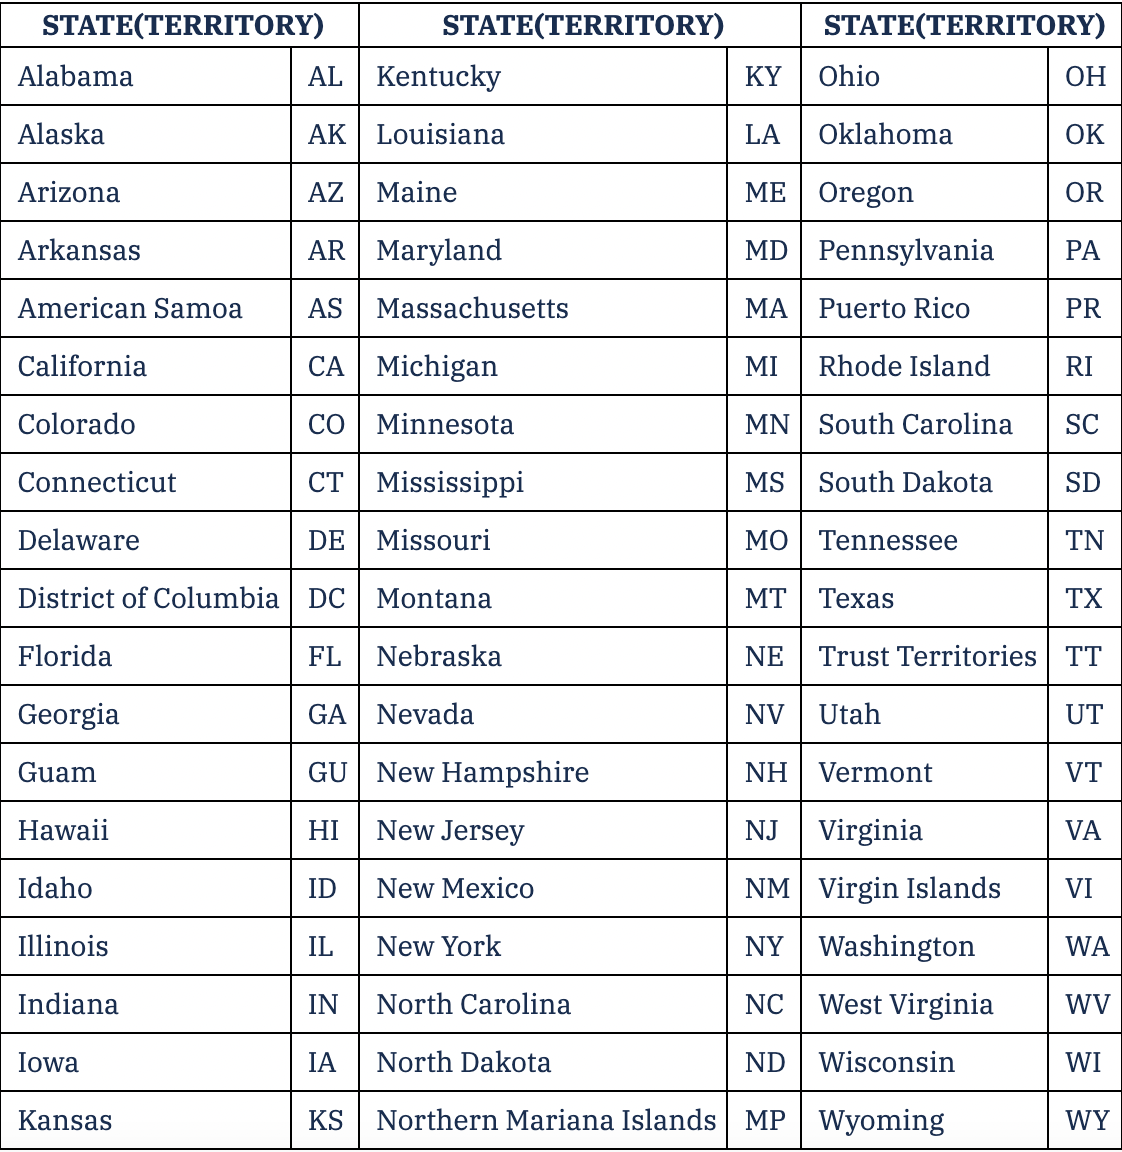

In [28]:
from IPython import display
display.Image("data/state code.png")

In [29]:
us_state_to_abbrev = {
"Alabama": "AL",
"Alaska": "AK",
"Arizona": "AZ",
"Arkansas": "AR",
"California": "CA",
"Colorado": "CO",
"Connecticut": "CT",
"Delaware": "DE",
"Florida": "FL",
"Georgia": "GA",
"Hawaii": "HI",
"Idaho": "ID",
"Illinois": "IL",
"Indiana": "IN",
"Iowa": "IA",
"Kansas": "KS",
"Kentucky": "KY",
"Louisiana": "LA",
"Maine": "ME",
"Maryland": "MD",
"Massachusetts": "MA",
"Michigan": "MI",
"Minnesota": "MN",
"Mississippi": "MS",
"Missouri": "MO",
"Montana": "MT",
"Nebraska": "NE",
"Nevada": "NV",
"New Hampshire": "NH",
"New Jersey": "NJ",
"New Mexico": "NM",
"New York": "NY",
"North Carolina": "NC",
"North Dakota": "ND",
"Ohio": "OH",
"Oklahoma": "OK",
"Oregon": "OR",
"Pennsylvania": "PA",
"Rhode Island": "RI",
"South Carolina": "SC",
"South Dakota": "SD",
"Tennessee": "TN",
"Texas": "TX",
"Utah": "UT",
"Vermont": "VT",
"Virginia": "VA",
"Washington": "WA",
"West Virginia": "WV",
"Wisconsin": "WI",
"Wyoming": "WY",
"District of Columbia": "DC",
"American Samoa": "AS",
"Guam": "GU",
"Northern Mariana Islands": "MP",
"Puerto Rico": "PR",
"United States Minor Outlying Islands": "UM",
"U.S. Virgin Islands": "VI",
}

# invert the dictionary
abbrev_to_us_state = dict(map(reversed, us_state_to_abbrev.items()))

In [30]:
cases = cases.replace(abbrev_to_us_state)

# Check if any state code not changed
pd.unique(cases[cases['state'].str.len() <= 2].reset_index()['state'])

array(['PW'], dtype=object)

PW stands for Palau. If this region is not included in vaccination, we can remove the datas from here:

In [31]:
vaccination_2021[vaccination_2021['state'] == 'Palau'] # No
vaccination_2022[vaccination_2022['state'] == 'Palau'] # No

# Remove PW from cases
mask = ~(cases['state'] == 'PW')
cases = cases[mask]

### Total cases and deaths are cumulative, but new cases and deaths are not, so we need to deal with them seperately:

In [32]:
# one dataset for total
cases_tot = cases[['date','state','tot_cases','tot_deaths','year','month','day']]

# one for new
cases_new = cases[['date','state','new_cases','new_deaths','year','month','day']]

## Total data: turn cummulative to incremental: (delete)

In [33]:
# Find out the maximum days
max_days = cases_tot.groupby(['state', 'year','month'])['day'].max().reset_index()
max_days = pd.DataFrame(max_days)

# merge on the original dataset with the maximum days
cases_tot_max = pd.merge(cases_tot, max_days, how = 'right', on=['state', 'year','month','day'])
cases_tot_max.loc[:,'tot_deaths'].isna().sum()

# No missing values

0

In [34]:
cases_tot_max

,date,state,tot_cases,tot_deaths,year,month,day
0,2021-01-28,Alabama,449087,7169,2021,1,28
1,2021-02-25,Alabama,490165,9741,2021,2,25
2,2021-03-25,Alabama,512669,10481,2021,3,25
3,2021-04-29,Alabama,527085,10876,2021,4,29
4,2021-05-27,Alabama,542828,11132,2021,5,27
...,...,...,...,...,...,...,...
1411,2022-08-25,Wyoming,174213,1877,2022,8,25
1412,2022-09-29,Wyoming,176728,1894,2022,9,29
1413,2022-10-27,Wyoming,178436,1908,2022,10,27
1414,2022-11-24,Wyoming,180426,1931,2022,11,24


### Split the datat by year

In [35]:
# 2021
cases_tot2021_acc = cases_tot_max[(cases_tot_max['year'] == 2021)]

# 2022
cases_tot2022_acc = cases_tot_max[(cases_tot_max['year'] == 2022)]

### Check duplicate rows and remove

In [36]:
# 2021
for i in pd.unique(cases_tot2021_acc['state']):
    for j in range(len(cases_tot2021_acc[cases_tot2021_acc['state'] == i])):
        if j >= 12:
            print(i)
            
# 2022
for i in pd.unique(cases_tot2022_acc['state']):
    for j in range(len(cases_tot2022_acc[cases_tot2022_acc['state'] == i])):
        if j >= 12:
            print(i)

# No duplicates

### Get incremental data
#### month i = month i - month (i-1) to get the incremental data of that month.

In [37]:
# 2021
def incre_2021(string):
    new_list = cases_tot2021_acc.groupby('state')[string].diff()
    fill_list = cases_tot2021_acc[cases_tot2021_acc['month'] == 1][string]
    result = new_list.fillna(pd.Series(fill_list))
    return result

total_cases_2021 = incre_2021('tot_cases')
total_deaths_2021 = incre_2021('tot_deaths')


# 2022
def incre_2022(string):
    new_list = cases_tot2022_acc.groupby('state')[string].diff()
    fill_list = cases_tot2022_acc[cases_tot2022_acc['month'] == 1][string]
    result = new_list.fillna(pd.Series(fill_list))
    return result

total_cases_2022 = incre_2022('tot_cases')
total_deaths_2022 = incre_2022('tot_deaths')

In [38]:
# create new dataframe: 2021
cases_tot_2021 = cases_tot2021_acc
cases_tot_2021['tot_cases'] = total_cases_2021
cases_tot_2021['tot_deaths'] = total_deaths_2021


# create new dataframe: 2022
cases_tot_2022 = cases_tot2022_acc
cases_tot_2022['tot_cases'] = total_cases_2022
cases_tot_2022['tot_deaths'] = total_deaths_2022

### Now we finish our tidying for total cases and deaths data:
#### Notice that the values in 2022 is always larger than 2021, it is because 2022 also includes the amount in 2021 (cumulative). I will leave it like this since we will work with proportion in the project

In [39]:
cases_tot_2021 = cases_tot_2021.reset_index()
cases_tot_2021

,index,date,state,tot_cases,tot_deaths,year,month,day
0,0,2021-01-28,Alabama,449087.0,7169.0,2021,1,28
1,1,2021-02-25,Alabama,41078.0,2572.0,2021,2,25
2,2,2021-03-25,Alabama,22504.0,740.0,2021,3,25
3,3,2021-04-29,Alabama,14416.0,395.0,2021,4,29
4,4,2021-05-27,Alabama,15743.0,256.0,2021,5,27
...,...,...,...,...,...,...,...,...
703,1399,2021-08-26,Wyoming,7905.0,59.0,2021,8,26
704,1400,2021-09-30,Wyoming,17437.0,161.0,2021,9,30
705,1401,2021-10-28,Wyoming,11947.0,178.0,2021,10,28
706,1402,2021-11-25,Wyoming,8352.0,173.0,2021,11,25


In [40]:
cases_tot_2022 = cases_tot_2022.reset_index()
cases_tot_2022

,index,date,state,tot_cases,tot_deaths,year,month,day
0,12,2022-01-27,Alabama,1161930.0,16914.0,2022,1,27
1,13,2022-02-24,Alabama,113427.0,1092.0,2022,2,24
2,14,2022-03-31,Alabama,19658.0,1278.0,2022,3,31
3,15,2022-04-28,Alabama,5259.0,274.0,2022,4,28
4,16,2022-05-26,Alabama,10247.0,93.0,2022,5,26
...,...,...,...,...,...,...,...,...
703,1411,2022-08-25,Wyoming,4182.0,21.0,2022,8,25
704,1412,2022-09-29,Wyoming,2515.0,17.0,2022,9,29
705,1413,2022-10-27,Wyoming,1708.0,14.0,2022,10,27
706,1414,2022-11-24,Wyoming,1990.0,23.0,2022,11,24


## New data:  add up the cases in each month

In [41]:
# Group by month
cases_new_max = cases_new.groupby(['state', 'year','month'])[['new_cases','new_deaths']].sum().reset_index()

# Check for null values
cases_new_max.loc[:,'new_cases'].isna().sum()
# No

0

### Split the datat by year

In [42]:
# 2021
cases_new2021 = cases_new_max[(cases_new_max['year'] == 2021)]

# 2022
cases_new2022 = cases_new_max[(cases_new_max['year'] == 2022)]

### Check duplicate rows and remove

In [43]:
# 2021
for i in pd.unique(cases_new2021['state']):
    for j in range(len(cases_new2021[cases_new2021['state'] == i])):
        if j >= 12:
            print(i)
            
# 2022
for i in pd.unique(cases_new2022['state']):
    for j in range(len(cases_new2022[cases_new2022['state'] == i])):
        if j >= 12:
            print(i)

# No duplicates

### Now we finish all our tidying for total cases and deaths data:
#### Notice that the values in 2022 is always larger than 2021, it is because 2022 also includes the amount in 2021 (cumulative). I will leave it like this since we will work with proportion in the project

In [44]:
cases_new2021 = cases_new2021.reset_index()
cases_new2021

,index,state,year,month,new_cases,new_deaths
0,0,Alabama,2021,1,92267,2395
1,1,Alabama,2021,2,41078,2572
2,2,Alabama,2021,3,22504,740
3,3,Alabama,2021,4,14416,395
4,4,Alabama,2021,5,15743,256
...,...,...,...,...,...,...
703,1399,Wyoming,2021,8,7905,59
704,1400,Wyoming,2021,9,17437,161
705,1401,Wyoming,2021,10,11947,178
706,1402,Wyoming,2021,11,8352,173


In [45]:
cases_new2022 = cases_new2022.reset_index()
cases_new2022

,index,state,year,month,new_cases,new_deaths
0,12,Alabama,2022,1,281623,461
1,13,Alabama,2022,2,113427,1092
2,14,Alabama,2022,3,19658,1278
3,15,Alabama,2022,4,5259,274
4,16,Alabama,2022,5,10247,93
...,...,...,...,...,...,...
703,1411,Wyoming,2022,8,4182,21
704,1412,Wyoming,2022,9,2515,17
705,1413,Wyoming,2022,10,1708,14
706,1414,Wyoming,2022,11,1990,23


##  Combine total cases and new cases back to the same dataset 

In [46]:
# 2021
cases_2021 = pd.merge(cases_tot_2021, cases_new2021, how = 'left', on=['state', 'year','month'])
cases_2021.isna().sum()

# 2022
cases_2022 = pd.merge(cases_tot_2022, cases_new2022, how = 'left', on=['state', 'year','month'])
cases_2022.isna().sum()

index_x       0
date          0
state         0
tot_cases     0
tot_deaths    0
year          0
month         0
day           0
index_y       0
new_cases     0
new_deaths    0
dtype: int64

In [47]:
cases_2021 = cases_2021[['date','year','month','state','tot_cases','tot_deaths','new_cases','new_deaths']]
cases_2022 = cases_2022[['date','year','month','state','tot_cases','tot_deaths','new_cases','new_deaths']]

## Now we finish all our tidying for cases:

In [48]:
cases_2021

,date,year,month,state,tot_cases,tot_deaths,new_cases,new_deaths
0,2021-01-28,2021,1,Alabama,449087.0,7169.0,92267,2395
1,2021-02-25,2021,2,Alabama,41078.0,2572.0,41078,2572
2,2021-03-25,2021,3,Alabama,22504.0,740.0,22504,740
3,2021-04-29,2021,4,Alabama,14416.0,395.0,14416,395
4,2021-05-27,2021,5,Alabama,15743.0,256.0,15743,256
...,...,...,...,...,...,...,...,...
703,2021-08-26,2021,8,Wyoming,7905.0,59.0,7905,59
704,2021-09-30,2021,9,Wyoming,17437.0,161.0,17437,161
705,2021-10-28,2021,10,Wyoming,11947.0,178.0,11947,178
706,2021-11-25,2021,11,Wyoming,8352.0,173.0,8352,173


In [49]:
cases_2022

,date,year,month,state,tot_cases,tot_deaths,new_cases,new_deaths
0,2022-01-27,2022,1,Alabama,1161930.0,16914.0,281623,461
1,2022-02-24,2022,2,Alabama,113427.0,1092.0,113427,1092
2,2022-03-31,2022,3,Alabama,19658.0,1278.0,19658,1278
3,2022-04-28,2022,4,Alabama,5259.0,274.0,5259,274
4,2022-05-26,2022,5,Alabama,10247.0,93.0,10247,93
...,...,...,...,...,...,...,...,...
703,2022-08-25,2022,8,Wyoming,4182.0,21.0,4182,21
704,2022-09-29,2022,9,Wyoming,2515.0,17.0,2515,17
705,2022-10-27,2022,10,Wyoming,1708.0,14.0,1708,14
706,2022-11-24,2022,11,Wyoming,1990.0,23.0,1990,23


<br>
<br>

# Merge the vaccination and cases datas by year

In [50]:
vaccination_2021

,index,state,year,month,day,total_vaccinations,total_distributed,people_vaccinated
0,0,Alabama,2021,1,31,353974.0,659400.0,298301.0
1,1,Alabama,2021,2,28,588528.0,742880.0,351444.0
2,2,Alabama,2021,3,31,786234.0,1394350.0,505394.0
3,3,Alabama,2021,4,30,862427.0,1291400.0,434379.0
4,4,Alabama,2021,5,30,430291.0,490560.0,176537.0
...,...,...,...,...,...,...,...,...
727,3020,Wyoming,2021,8,31,30808.0,56310.0,20522.0
728,3021,Wyoming,2021,9,30,42496.0,72060.0,18503.0
729,3022,Wyoming,2021,10,31,48391.0,84750.0,13649.0
730,3023,Wyoming,2021,11,30,63641.0,70700.0,16197.0


In [51]:
cases_2021

,date,year,month,state,tot_cases,tot_deaths,new_cases,new_deaths
0,2021-01-28,2021,1,Alabama,449087.0,7169.0,92267,2395
1,2021-02-25,2021,2,Alabama,41078.0,2572.0,41078,2572
2,2021-03-25,2021,3,Alabama,22504.0,740.0,22504,740
3,2021-04-29,2021,4,Alabama,14416.0,395.0,14416,395
4,2021-05-27,2021,5,Alabama,15743.0,256.0,15743,256
...,...,...,...,...,...,...,...,...
703,2021-08-26,2021,8,Wyoming,7905.0,59.0,7905,59
704,2021-09-30,2021,9,Wyoming,17437.0,161.0,17437,161
705,2021-10-28,2021,10,Wyoming,11947.0,178.0,11947,178
706,2021-11-25,2021,11,Wyoming,8352.0,173.0,8352,173


In [52]:
# 2021
data_2021 = pd.merge(cases_2021, vaccination_2021, how = 'left', on=['state', 'year','month'])
data_2021.isna().sum()

# 2022
data_2022 = pd.merge(cases_2022, vaccination_2022, how = 'left', on=['state', 'year','month'])
data_2022.isna().sum()

date                    0
year                    0
month                   0
state                   0
tot_cases               0
tot_deaths              0
new_cases               0
new_deaths              0
day                   192
total_vaccinations    192
total_distributed     192
people_vaccinated     192
dtype: int64

### Delete the region that is not included in both datasets

In [53]:
# Get a list of states containing null values
# 2021
ace_data = data_2021.loc[:,'total_distributed']
empty_list_2021 = []
for i in range(len(data_2021)):
    if pd.isna(ace_data[i]) == True :
        empty_list_2021.append(data_2021['state'][i])
        
pd.unique(empty_list_2021)



# 2022
ace_data = data_2022.loc[:,'total_distributed']
empty_list_2022 = []
for i in range(len(data_2022)):
    if pd.isna(ace_data[i]) == True :
        empty_list_2022.append(data_2022['state'][i])
        
pd.unique(empty_list_2022)

array(['American Samoa', 'California', 'FSM', 'Idaho', 'Illinois',
       'Kansas', 'NYC', 'Nevada', 'New Hampshire', 'New York',
       'Northern Mariana Islands', 'Puerto Rico', 'RMI', 'Texas',
       'U.S. Virgin Islands', 'Wyoming'], dtype=object)

In [54]:
missing_2021 = ['FSM', 'Illinois', 'NYC', 'New Hampshire', 'New York', 'PW','Pennsylvania', 'RMI', 'U.S. Virgin Islands']
missing_2022 = ['American Samoa', 'California', 'FSM', 'Idaho', 'Illinois','Kansas', 'NYC', 'Nevada', 'New Hampshire', 'New York',
                 'Northern Mariana Islands', 'PW', 'Puerto Rico', 'RMI', 'Texas','U.S. Virgin Islands', 'Wyoming']

In [55]:
# 2021
mask = ~data_2021['state'].isin(missing_2021)
data_2021 = data_2021[mask]
data_2021.isna().sum()

# 2022
mask = ~data_2022['state'].isin(missing_2022)
data_2022 = data_2022[mask]
data_2022.isna().sum()

# No null values

date                  0
year                  0
month                 0
state                 0
tot_cases             0
tot_deaths            0
new_cases             0
new_deaths            0
day                   0
total_vaccinations    0
total_distributed     0
people_vaccinated     0
dtype: int64

In [56]:
data_2021 = data_2021[['year','month','state','new_cases','new_deaths','total_vaccinations','total_distributed','people_vaccinated']]
data_2022 = data_2022[['year','month','state','new_cases','new_deaths','total_vaccinations','total_distributed','people_vaccinated']]

<br>
<br>

# Final look of the two datas:

In [59]:
data_2021
data_2021.to_csv('data_2021.csv')

In [60]:
data_2022
data_2022.to_csv('data_2022.csv')